In [3]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/PRSA_data_2010.1.1-2014.12.31.csv?token=ATB7FVZXSWBIQ3BHNIFZPBLBN6TDS")

In [4]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [5]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


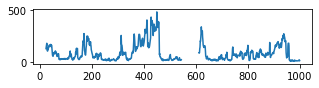

In [6]:
plt.figure(figsize=(5,1))
plt.plot(data['pm2.5'][:1000])

In [7]:
data['cbwd']=data['cbwd'].factorize()[0]

In [8]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [9]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,0,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,0,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,0,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,0,246.72,0,0


In [10]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [11]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [12]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [13]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [14]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

35035
4358
4359
8741


In [15]:
print(trainX.shape)
print(trainY.shape)

(35035, 24, 8)
(35035,)


# new

# lstmrescnn

In [14]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 24, 64)       18688       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 64)       12352       lstm[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 24, 64)       8256        conv1d[0][0]                     
_______________________________________________________________________________________

In [15]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 24, 64)       18688       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 24, 64)       12352       lstm_1[0][0]                     
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 24, 64)       8256        conv1d_5[0][0]                   
_______________________________________________________________________________________

In [16]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 24, 64)       18688       input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 24, 64)       12352       lstm_2[0][0]                     
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 24, 64)       8256        conv1d_10[0][0]                  
_______________________________________________________________________________________

In [17]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 24, 64)       18688       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 64)       12352       lstm_3[0][0]                     
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 24, 64)       8256        conv1d_15[0][0]                  
_______________________________________________________________________________________

In [18]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 24, 64)       18688       input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 24, 64)       12352       lstm_4[0][0]                     
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 24, 64)       8256        conv1d_20[0][0]                  
_______________________________________________________________________________________

349/351 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00060: val_loss did not improve from 0.02565
351/351 [==============================] - 7s 20ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 61/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00061: val_loss did not improve from 0.02565
351/351 [==============================] - 7s 20ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 62/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00062: val_loss did not improve from 0.02565
351/351 [==============================] - 7s 20ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 63/130
350/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00063: val_loss did not improve from 0.02565
351/351 [==============================] - 7s 20ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 64/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00064: val_loss did not improve from 0.02565
351

In [19]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 24, 64)       18688       input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 24, 64)       12352       lstm_5[0][0]                     
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 24, 64)       8256        conv1d_25[0][0]                  
______________________________________________________________________________________

Epoch 24/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00024: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 16ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 25/130
351/351 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00025: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 26/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00026: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 16ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 27/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00027: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 16ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 28/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00028: val_loss did not improve fro

350/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00098: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 99/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00099: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 100/130
351/351 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00100: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 101/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00101: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 102/130
351/351 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00102: val_loss did not improve from 0.02565


In [20]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 24, 64)       18688       input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 24, 64)       12352       lstm_6[0][0]                     
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 24, 64)       8256        conv1d_30[0][0]                  
______________________________________________________________________________________

Epoch 24/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00024: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 25/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00025: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 26/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00026: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 27/130
348/351 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00027: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 28/130
350/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00028: val_loss did not improve fro

348/351 [============================>.] - ETA: 0s - loss: 0.0231- ETA: 0s - loss: 0
Epoch 00098: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 99/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00099: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 100/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00100: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 101/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00101: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 102/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00102: val_loss did not im

In [21]:
in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 24, 64)       18688       input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 24, 64)       12352       lstm_7[0][0]                     
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 24, 64)       8256        conv1d_35[0][0]                  
______________________________________________________________________________________

Epoch 24/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00024: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 25/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00025: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 26/130
351/351 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00026: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 27/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00027: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 28/130
351/351 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00028: val_loss did not improve fro

350/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00098: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 99/130
348/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00099: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 100/130
350/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00100: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 101/130
351/351 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00101: val_loss did not improve from 0.02565
351/351 [==============================] - 6s 17ms/step - loss: 0.0231 - val_loss: 0.0257
Epoch 102/130
349/351 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00102: val_loss did not improve from 0.02565


In [22]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 24, 64)       18688       input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 24, 64)       12352       lstm_8[0][0]                     
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 24, 64)       8256        conv1d_40[0][0]                  
______________________________________________________________________________________

Epoch 20/130
350/351 [============================>.] - ETA: 0s - loss: 4.6691e-04
Epoch 00020: val_loss did not improve from 0.00048
351/351 [==============================] - 6s 17ms/step - loss: 4.6708e-04 - val_loss: 4.9219e-04
Epoch 21/130
348/351 [============================>.] - ETA: 0s - loss: 4.4885e-04
Epoch 00021: val_loss did not improve from 0.00048
351/351 [==============================] - 6s 17ms/step - loss: 4.4986e-04 - val_loss: 5.2148e-04
Epoch 22/130
348/351 [============================>.] - ETA: 0s - loss: 4.6779e-04
Epoch 00022: val_loss did not improve from 0.00048
351/351 [==============================] - 6s 16ms/step - loss: 4.6652e-04 - val_loss: 4.8096e-04
Epoch 23/130
349/351 [============================>.] - ETA: 0s - loss: 4.4779e-04
Epoch 00023: val_loss did not improve from 0.00048
351/351 [==============================] - 6s 17ms/step - loss: 4.4707e-04 - val_loss: 4.7958e-04
Epoch 24/130
351/351 [==============================] - ETA: 0s - loss: 

Epoch 54/130
349/351 [============================>.] - ETA: 0s - loss: 4.2669e-04
Epoch 00054: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 4.2686e-04 - val_loss: 4.8125e-04
Epoch 55/130
349/351 [============================>.] - ETA: 0s - loss: 4.1757e-04
Epoch 00055: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 4.1666e-04 - val_loss: 4.6540e-04
Epoch 56/130
349/351 [============================>.] - ETA: 0s - loss: 4.1194e-04
Epoch 00056: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 4.1256e-04 - val_loss: 5.2985e-04
Epoch 57/130
348/351 [============================>.] - ETA: 0s - loss: 4.1611e-04
Epoch 00057: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 4.1610e-04 - val_loss: 4.7982e-04
Epoch 58/130
350/351 [============================>.] - ETA: 0s - loss: 

350/351 [============================>.] - ETA: 0s - loss: 3.7022e-04
Epoch 00124: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 3.6993e-04 - val_loss: 5.2069e-04
Epoch 125/130
351/351 [==============================] - ETA: 0s - loss: 3.7669e-04
Epoch 00125: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 3.7669e-04 - val_loss: 5.2807e-04
Epoch 126/130
350/351 [============================>.] - ETA: 0s - loss: 3.6863e-04
Epoch 00126: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 3.6891e-04 - val_loss: 5.5249e-04
Epoch 127/130
351/351 [==============================] - ETA: 0s - loss: 3.7709e-04
Epoch 00127: val_loss did not improve from 0.00046
351/351 [==============================] - 6s 17ms/step - loss: 3.7709e-04 - val_loss: 5.2890e-04
Epoch 128/130
348/351 [============================>.] - ETA: 0s - loss: 3.6581e-0

In [2]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

NameError: name 'Input' is not defined

In [1]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(1).hdf5")

NameError: name 'model' is not defined

In [25]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01618
Test MAE: 0.00940
Test MAPE: 0.08561


In [26]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(2).hdf5")

In [27]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01612
Test MAE: 0.00959
Test MAPE: 0.08885


In [28]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(3).hdf5")

In [29]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01610
Test MAE: 0.00951
Test MAPE: 0.08826


In [30]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(4).hdf5")

In [31]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [32]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(5).hdf5")

In [33]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [34]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(6).hdf5")

In [35]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [36]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(7).hdf5")

In [37]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [38]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(8).hdf5")

In [39]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [40]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(9).hdf5")

In [41]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01642
Test MAE: 0.00988
Test MAPE: 0.09243


In [42]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_lstm-rescnn(1).hdf5")

In [43]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01618
Test MAE: 0.00940
Test MAPE: 0.08561


### Bidirectional LSTM

In [44]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 170)               63920     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1092/1095 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(1).hdf5
1095/1095 [==============================] - 9s 8ms/step - loss: 0.0011 - val_loss: 0.0000e+00
Epoch 2/50
1090/1095 [=============

Epoch 33/50
1089/1095 [============================>.] - ETA: 0s - loss: 4.4704e-04
Epoch 00033: val_loss did not improve from 0.00000
1095/1095 [==============================] - 9s 8ms/step - loss: 4.4747e-04 - val_loss: 0.0000e+00
Epoch 34/50
1092/1095 [============================>.] - ETA: 0s - loss: 4.4604e-04
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 9s 8ms/step - loss: 4.4691e-04 - val_loss: 0.0000e+00
Epoch 35/50
1093/1095 [============================>.] - ETA: 0s - loss: 4.4633e-04
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 9s 8ms/step - loss: 4.4607e-04 - val_loss: 0.0000e+00
Epoch 36/50
1090/1095 [============================>.] - ETA: 0s - loss: 4.4577e-04
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 9s 8ms/step - loss: 4.4548e-04 - val_loss: 0.0000e+00
Epoch 37/50
1090/1095 [============================>.] - ETA: 0s

In [45]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1092/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(2).hdf5
1095/1095 [==============================] - 9s 8ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 2/50
1093/1095 [=============

Epoch 34/50
1093/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 35/50
1093/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 36/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 37/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00037: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 38/50
1094/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00038: val

In [46]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1095/1095 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(3).hdf5
1095/1095 [==============================] - 8s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 2/50
1091/1095 [=============

Epoch 34/50
1090/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 35/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 8s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 36/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 37/50
1088/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00037: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 38/50
1094/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00038: val

In [47]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(4).hdf5
1095/1095 [==============================] - 8s 8ms/step - loss: 0.0014 - val_loss: 0.0000e+00
Epoch 2/50
1093/1095 [=============

Epoch 33/50
1088/1095 [============================>.] - ETA: 0s - loss: 4.3577e-04
Epoch 00033: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4865e-04 - val_loss: 0.0000e+00
Epoch 34/50
1088/1095 [============================>.] - ETA: 0s - loss: 4.4927e-04
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4865e-04 - val_loss: 0.0000e+00
Epoch 35/50
1095/1095 [==============================] - ETA: 0s - loss: 4.4575e-04
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4575e-04 - val_loss: 0.0000e+00
Epoch 36/50
1092/1095 [============================>.] - ETA: 0s - loss: 4.4468e-04
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4470e-04 - val_loss: 0.0000e+00
Epoch 37/50
1095/1095 [==============================] - ETA: 0s

In [48]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1095/1095 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(5).hdf5
1095/1095 [==============================] - 8s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 2/50
1088/1095 [=============

In [49]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1090/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(6).hdf5
1095/1095 [==============================] - 8s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 2/50
1092/1095 [=============

Epoch 34/50
1093/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 35/50
1093/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 36/50
1091/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 37/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00037: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 38/50
1091/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00038: val

In [50]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1093/1095 [============================>.] - ETA: 0s - loss: 0.0012WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/save

Epoch 32/50
1094/1095 [============================>.] - ETA: 0s - loss: 4.4889e-04
Epoch 00032: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4868e-04 - val_loss: 0.0000e+00
Epoch 33/50
1088/1095 [============================>.] - ETA: 0s - loss: 4.4730e-04
Epoch 00033: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4647e-04 - val_loss: 0.0000e+00
Epoch 34/50
1093/1095 [============================>.] - ETA: 0s - loss: 4.4440e-04
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4411e-04 - val_loss: 0.0000e+00
Epoch 35/50
1091/1095 [============================>.] - ETA: 0s - loss: 4.4780e-04
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 4.4741e-04 - val_loss: 0.0000e+00
Epoch 36/50
1088/1095 [============================>.] - ETA: 0s

In [51]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1094/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(8).hdf5
1095/1095 [==============================] - 8s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 2/50
1088/1095 [=============

Epoch 34/50
1095/1095 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 35/50
1094/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 36/50
1091/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 37/50
1094/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00037: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 38/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00038: val

In [52]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1092/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(9).hdf5
1095/1095 [==============================] - 8s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 2/50
1090/1095 [=============

Epoch 34/50
1092/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00034: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 35/50
1092/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00035: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 36/50
1088/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00036: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 37/50
1095/1095 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00037: val_loss did not improve from 0.00000
1095/1095 [==============================] - 7s 7ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 38/50
1094/1095 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 00038: val

In [53]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#odel.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 170)               63920     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1089/1095 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00001: val_loss improved from inf to 0.00000, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights\pm2.5_onestep_timebilstm(1).hdf5
1095/1095 [==============================] - 9s 8ms/step - loss: 0.0012 - val_loss: 0.0000e+00
Epoch 2/50
1088/1095 [=============

In [54]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(1).hdf5")

In [55]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01976
Test MAE: 0.01346
Test MAPE: 0.12520


In [56]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(2).hdf5")

In [57]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [58]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(3).hdf5")

In [59]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [60]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(4).hdf5")

In [61]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02284
Test MAE: 0.01815
Test MAPE: 0.23168


In [62]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(5).hdf5")

In [63]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [64]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(6).hdf5")

In [65]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [66]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(7).hdf5")

In [67]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01844
Test MAE: 0.01209
Test MAPE: 0.12818


In [68]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(8).hdf5")

In [69]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [70]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(9).hdf5")

In [71]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.14687
Test MAE: 0.12126
Test MAPE: 1.00000


In [72]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_timebilstm(1).hdf5")

In [73]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01976
Test MAE: 0.01346
Test MAPE: 0.12520


### 1d-CNN

In [74]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(1).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 24, 64)          

Epoch 63/200
1080/1095 [============================>.] - ETA: 0s - loss: 4.2673e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2572e-04 - val_loss: 0.0000e+00
Epoch 64/200
1079/1095 [============================>.] - ETA: 0s - loss: 4.2912e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2749e-04 - val_loss: 0.0000e+00
Epoch 65/200
1078/1095 [============================>.] - ETA: 0s - loss: 4.2657e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2456e-04 - val_loss: 0.0000e+00
Epoch 66/200
1085/1095 [============================>.] - ETA: 0s - loss: 4.2392e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2343e-04 - val_loss: 0.0000e+00
Epoch 67/200
1092/1095 [============================>.] - ET

Epoch 98/200
1083/1095 [============================>.] - ETA: 0s - loss: 4.0098e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0121e-04 - val_loss: 0.0000e+00
Epoch 99/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.0111e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0037e-04 - val_loss: 0.0000e+00
Epoch 100/200
1090/1095 [============================>.] - ETA: 0s - loss: 3.9865e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9830e-04 - val_loss: 0.0000e+00
Epoch 101/200
1079/1095 [============================>.] - ETA: 0s - loss: 3.8123e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9490e-04 - val_loss: 0.0000e+00
Epoch 102/200
1084/1095 [============================>.] -

Epoch 133/200
1078/1095 [============================>.] - ETA: 0s - loss: 3.7359e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7223e-04 - val_loss: 0.0000e+00
Epoch 134/200
1086/1095 [============================>.] - ETA: 0s - loss: 3.7543e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7504e-04 - val_loss: 0.0000e+00
Epoch 135/200
1094/1095 [============================>.] - ETA: 0s - loss: 3.8063e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8044e-04 - val_loss: 0.0000e+00
Epoch 136/200
1081/1095 [============================>.] - ETA: 0s - loss: 3.7815e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7829e-04 - val_loss: 0.0000e+00
Epoch 137/200
1081/1095 [============================>.]

Epoch 168/200
1086/1095 [============================>.] - ETA: 0s - loss: 3.5572e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5669e-04 - val_loss: 0.0000e+00
Epoch 169/200
1080/1095 [============================>.] - ETA: 0s - loss: 3.5621e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5640e-04 - val_loss: 0.0000e+00
Epoch 170/200
1083/1095 [============================>.] - ETA: 0s - loss: 3.5893e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5750e-04 - val_loss: 0.0000e+00
Epoch 171/200
1085/1095 [============================>.] - ETA: 0s - loss: 3.5698e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5675e-04 - val_loss: 0.0000e+00
Epoch 172/200
1093/1095 [============================>.]

In [75]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(2).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 24, 64)          

Epoch 63/200
1080/1095 [============================>.] - ETA: 0s - loss: 4.2903e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2777e-04 - val_loss: 0.0000e+00
Epoch 64/200
1082/1095 [============================>.] - ETA: 0s - loss: 4.3089e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2892e-04 - val_loss: 0.0000e+00
Epoch 65/200
1093/1095 [============================>.] - ETA: 0s - loss: 4.3112e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3113e-04 - val_loss: 0.0000e+00
Epoch 66/200
1076/1095 [============================>.] - ETA: 0s - loss: 4.2243e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2290e-04 - val_loss: 0.0000e+00
Epoch 67/200
1088/1095 [============================>.] - ET

Epoch 98/200
1079/1095 [============================>.] - ETA: 0s - loss: 4.1143e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1089e-04 - val_loss: 0.0000e+00
Epoch 99/200
1078/1095 [============================>.] - ETA: 0s - loss: 4.0920e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0825e-04 - val_loss: 0.0000e+00
Epoch 100/200
1094/1095 [============================>.] - ETA: 0s - loss: 4.1179e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1159e-04 - val_loss: 0.0000e+00
Epoch 101/200
1092/1095 [============================>.] - ETA: 0s - loss: 4.0468e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0416e-04 - val_loss: 0.0000e+00
Epoch 102/200
1087/1095 [============================>.] -

Epoch 133/200
1080/1095 [============================>.] - ETA: 0s - loss: 3.9283e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9221e-04 - val_loss: 0.0000e+00
Epoch 134/200
1082/1095 [============================>.] - ETA: 0s - loss: 3.9168e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9205e-04 - val_loss: 0.0000e+00
Epoch 135/200
1092/1095 [============================>.] - ETA: 0s - loss: 3.9129e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9091e-04 - val_loss: 0.0000e+00
Epoch 136/200
1088/1095 [============================>.] - ETA: 0s - loss: 3.9643e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9729e-04 - val_loss: 0.0000e+00
Epoch 137/200
1085/1095 [============================>.]

Epoch 168/200
1080/1095 [============================>.] - ETA: 0s - loss: 3.7742e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8117e-04 - val_loss: 0.0000e+00
Epoch 169/200
1086/1095 [============================>.] - ETA: 0s - loss: 3.9114e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9169e-04 - val_loss: 0.0000e+00
Epoch 170/200
1077/1095 [============================>.] - ETA: 0s - loss: 3.8977e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9078e-04 - val_loss: 0.0000e+00
Epoch 171/200
1078/1095 [============================>.] - ETA: 0s - loss: 3.8040e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7998e-04 - val_loss: 0.0000e+00
Epoch 172/200
1093/1095 [============================>.]

In [76]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(3).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 24, 64)          

Epoch 63/200
1074/1095 [============================>.] - ETA: 0s - loss: 4.4058e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.4056e-04 - val_loss: 0.0000e+00
Epoch 64/200
1077/1095 [============================>.] - ETA: 0s - loss: 4.4432e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.4223e-04 - val_loss: 0.0000e+00
Epoch 65/200
1083/1095 [============================>.] - ETA: 0s - loss: 4.4115e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.4030e-04 - val_loss: 0.0000e+00
Epoch 66/200
1086/1095 [============================>.] - ETA: 0s - loss: 4.3514e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3575e-04 - val_loss: 0.0000e+00
Epoch 67/200
1085/1095 [============================>.] - ET

Epoch 98/200
1086/1095 [============================>.] - ETA: 0s - loss: 4.2740e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2835e-04 - val_loss: 0.0000e+00
Epoch 99/200
1088/1095 [============================>.] - ETA: 0s - loss: 4.2446e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2460e-04 - val_loss: 0.0000e+00
Epoch 100/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.2935e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2940e-04 - val_loss: 0.0000e+00
Epoch 101/200
1095/1095 [==============================] - ETA: 0s - loss: 4.2155e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2155e-04 - val_loss: 0.0000e+00
Epoch 102/200
1095/1095 [==============================] -

Epoch 133/200
1095/1095 [==============================] - ETA: 0s - loss: 4.1304e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1304e-04 - val_loss: 0.0000e+00
Epoch 134/200
1082/1095 [============================>.] - ETA: 0s - loss: 4.1093e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0872e-04 - val_loss: 0.0000e+00
Epoch 135/200
1094/1095 [============================>.] - ETA: 0s - loss: 4.0614e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0613e-04 - val_loss: 0.0000e+00
Epoch 136/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.0709e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0619e-04 - val_loss: 0.0000e+00
Epoch 137/200
1084/1095 [============================>.]

Epoch 168/200
1094/1095 [============================>.] - ETA: 0s - loss: 3.9606e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9599e-04 - val_loss: 0.0000e+00
Epoch 169/200
1092/1095 [============================>.] - ETA: 0s - loss: 4.0241e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0258e-04 - val_loss: 0.0000e+00
Epoch 170/200
1084/1095 [============================>.] - ETA: 0s - loss: 3.9977e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9924e-04 - val_loss: 0.0000e+00
Epoch 171/200
1093/1095 [============================>.] - ETA: 0s - loss: 3.9319e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9281e-04 - val_loss: 0.0000e+00
Epoch 172/200
1086/1095 [============================>.]

In [77]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(4).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 24, 64)          

1092/1095 [============================>.] - ETA: 0s - loss: 4.1668e-0 - ETA: 0s - loss: 4.1586e-04
Epoch 00061: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 5ms/step - loss: 4.1691e-04 - val_loss: 0.0000e+00
Epoch 62/200
1092/1095 [============================>.] - ETA: 0s - loss: 4.2018e-04
Epoch 00062: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 5ms/step - loss: 4.1954e-04 - val_loss: 0.0000e+00
Epoch 63/200
1094/1095 [============================>.] - ETA: 0s - loss: 4.0781e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 5ms/step - loss: 4.1427e-04 - val_loss: 0.0000e+00
Epoch 64/200
1095/1095 [==============================] - ETA: 0s - loss: 4.2039e-04- ETA: 0s - loss: 4.2283
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 5ms/step - loss: 4.2039e-04 - val_loss: 0.0000e+00
Epoch 65/200
1086/109

Epoch 95/200
1094/1095 [============================>.] - ETA: 0s - loss: 3.8875e-04
Epoch 00095: val_loss did not improve from 0.00000
1095/1095 [==============================] - 11s 10ms/step - loss: 3.8919e-04 - val_loss: 0.0000e+00
Epoch 96/200
1091/1095 [============================>.] - ETA: 0s - loss: 4.0026e-04
Epoch 00096: val_loss did not improve from 0.00000
1095/1095 [==============================] - 10s 9ms/step - loss: 3.9988e-04 - val_loss: 0.0000e+00
Epoch 97/200
1092/1095 [============================>.] - ETA: 0s - loss: 3.8363e-04
Epoch 00097: val_loss did not improve from 0.00000
1095/1095 [==============================] - 9s 9ms/step - loss: 3.8381e-04 - val_loss: 0.0000e+00
Epoch 98/200
1089/1095 [============================>.] - ETA: 0s - loss: 3.9185e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 5ms/step - loss: 3.9072e-04 - val_loss: 0.0000e+00
Epoch 99/200
1091/1095 [============================>.] -

Epoch 164/200
1088/1095 [============================>.] - ETA: 0s - loss: 3.6545e-04
Epoch 00164: val_loss did not improve from 0.00000
1095/1095 [==============================] - 4s 4ms/step - loss: 3.6517e-04 - val_loss: 0.0000e+00
Epoch 165/200
1089/1095 [============================>.] - ETA: 0s - loss: 3.6663e-04
Epoch 00165: val_loss did not improve from 0.00000
1095/1095 [==============================] - 5s 4ms/step - loss: 3.6630e-04 - val_loss: 0.0000e+00
Epoch 166/200
1091/1095 [============================>.] - ETA: 0s - loss: 3.6560e-04
Epoch 00166: val_loss did not improve from 0.00000
1095/1095 [==============================] - 4s 4ms/step - loss: 3.6551e-04 - val_loss: 0.0000e+00
Epoch 167/200
1086/1095 [============================>.] - ETA: 0s - loss: 3.6286e-04
Epoch 00167: val_loss did not improve from 0.00000
1095/1095 [==============================] - 4s 4ms/step - loss: 3.6328e-04 - val_loss: 0.0000e+00
Epoch 168/200
1081/1095 [============================>.]

In [14]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(5).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 64)            1088      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 64)            4160      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 64)           

Epoch 63/200
1095/1095 [==============================] - ETA: 0s - loss: 4.1322e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1322e-04 - val_loss: 0.0000e+00
Epoch 64/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.1349e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1248e-04 - val_loss: 0.0000e+00
Epoch 65/200
1090/1095 [============================>.] - ETA: 0s - loss: 4.0687e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0690e-04 - val_loss: 0.0000e+00
Epoch 66/200
1083/1095 [============================>.] - ETA: 0s - loss: 4.0517e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0556e-04 - val_loss: 0.0000e+00
Epoch 67/200
1091/1095 [============================>.] - ET

Epoch 98/200
1088/1095 [============================>.] - ETA: 0s - loss: 3.7650e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7650e-04 - val_loss: 0.0000e+00
Epoch 99/200
1087/1095 [============================>.] - ETA: 0s - loss: 3.7294e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7305e-04 - val_loss: 0.0000e+00
Epoch 100/200
1093/1095 [============================>.] - ETA: 0s - loss: 3.7762e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7728e-04 - val_loss: 0.0000e+00
Epoch 101/200
1081/1095 [============================>.] - ETA: 0s - loss: 3.7403e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7275e-04 - val_loss: 0.0000e+00
Epoch 102/200
1088/1095 [============================>.] -

Epoch 133/200
1083/1095 [============================>.] - ETA: 0s - loss: 3.5099e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5014e-04 - val_loss: 0.0000e+00
Epoch 134/200
1090/1095 [============================>.] - ETA: 0s - loss: 3.5415e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5315e-04 - val_loss: 0.0000e+00
Epoch 135/200
1095/1095 [==============================] - ETA: 0s - loss: 3.6065e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.6065e-04 - val_loss: 0.0000e+00
Epoch 136/200
1092/1095 [============================>.] - ETA: 0s - loss: 3.5162e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5140e-04 - val_loss: 0.0000e+00
Epoch 137/200
1088/1095 [============================>.]

Epoch 168/200
1077/1095 [============================>.] - ETA: 0s - loss: 3.2267e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.2300e-04 - val_loss: 0.0000e+00
Epoch 169/200
1092/1095 [============================>.] - ETA: 0s - loss: 3.2502e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.2454e-04 - val_loss: 0.0000e+00
Epoch 170/200
1078/1095 [============================>.] - ETA: 0s - loss: 3.2906e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.3067e-04 - val_loss: 0.0000e+00
Epoch 171/200
1090/1095 [============================>.] - ETA: 0s - loss: 3.3491e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.3450e-04 - val_loss: 0.0000e+00
Epoch 172/200
1094/1095 [============================>.]

In [15]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(6).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 64)            1088      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 64)            4160      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 64)           

Epoch 63/200
1093/1095 [============================>.] - ETA: 0s - loss: 4.2938e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3006e-04 - val_loss: 0.0000e+00
Epoch 64/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.2698e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2638e-04 - val_loss: 0.0000e+00
Epoch 65/200
1090/1095 [============================>.] - ETA: 0s - loss: 4.3017e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2912e-04 - val_loss: 0.0000e+00
Epoch 66/200
1081/1095 [============================>.] - ETA: 0s - loss: 4.3076e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2984e-04 - val_loss: 0.0000e+00
Epoch 67/200
1089/1095 [============================>.] - ET

Epoch 98/200
1085/1095 [============================>.] - ETA: 0s - loss: 4.1399e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1360e-04 - val_loss: 0.0000e+00
Epoch 99/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.1465e-04- ETA: 0s - loss: 4.1
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1393e-04 - val_loss: 0.0000e+00
Epoch 100/200
1086/1095 [============================>.] - ETA: 0s - loss: 4.0681e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0708e-04 - val_loss: 0.0000e+00
Epoch 101/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.1756e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1670e-04 - val_loss: 0.0000e+00
Epoch 102/200
1092/1095 [============

Epoch 133/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.0327e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0242e-04 - val_loss: 0.0000e+00
Epoch 134/200
1092/1095 [============================>.] - ETA: 0s - loss: 4.0156e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0136e-04 - val_loss: 0.0000e+00
Epoch 135/200
1084/1095 [============================>.] - ETA: 0s - loss: 3.9561e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9498e-04 - val_loss: 0.0000e+00
Epoch 136/200
1093/1095 [============================>.] - ETA: 0s - loss: 3.9946e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9971e-04 - val_loss: 0.0000e+00
Epoch 137/200
1078/1095 [============================>.]

Epoch 168/200
1090/1095 [============================>.] - ETA: 0s - loss: 3.8600e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8626e-04 - val_loss: 0.0000e+00
Epoch 169/200
1082/1095 [============================>.] - ETA: 0s - loss: 3.8806e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8732e-04 - val_loss: 0.0000e+00
Epoch 170/200
1094/1095 [============================>.] - ETA: 0s - loss: 3.8383e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8373e-04 - val_loss: 0.0000e+00
Epoch 171/200
1094/1095 [============================>.] - ETA: 0s - loss: 3.9931e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9909e-04 - val_loss: 0.0000e+00
Epoch 172/200
1091/1095 [============================>.]

In [16]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(7).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24, 64)           

Epoch 63/200
1093/1095 [============================>.] - ETA: 0s - loss: 4.3967e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3936e-04 - val_loss: 0.0000e+00
Epoch 64/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.3393e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3447e-04 - val_loss: 0.0000e+00
Epoch 65/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.3028e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3109e-04 - val_loss: 0.0000e+00
Epoch 66/200
1088/1095 [============================>.] - ETA: 0s - loss: 4.3169e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3202e-04 - val_loss: 0.0000e+00
Epoch 67/200
1093/1095 [============================>.] - ET

Epoch 98/200
1090/1095 [============================>.] - ETA: 0s - loss: 4.1628e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1862e-04 - val_loss: 0.0000e+00
Epoch 99/200
1080/1095 [============================>.] - ETA: 0s - loss: 4.1716e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1907e-04 - val_loss: 0.0000e+00
Epoch 100/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.1910e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1750e-04 - val_loss: 0.0000e+00
Epoch 101/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.3178e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3038e-04 - val_loss: 0.0000e+00
Epoch 102/200
1089/1095 [============================>.] -

Epoch 133/200
1088/1095 [============================>.] - ETA: 0s - loss: 4.1100e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1017e-04 - val_loss: 0.0000e+00
Epoch 134/200
1079/1095 [============================>.] - ETA: 0s - loss: 4.1502e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1230e-04 - val_loss: 0.0000e+00
Epoch 135/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.0441e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0425e-04 - val_loss: 0.0000e+00
Epoch 136/200
1090/1095 [============================>.] - ETA: 0s - loss: 4.0939e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1103e-04 - val_loss: 0.0000e+00
Epoch 137/200
1083/1095 [============================>.]

Epoch 168/200
1080/1095 [============================>.] - ETA: 0s - loss: 4.0032e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0033e-04 - val_loss: 0.0000e+00
Epoch 169/200
1088/1095 [============================>.] - ETA: 0s - loss: 4.0044e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0188e-04 - val_loss: 0.0000e+00
Epoch 170/200
1085/1095 [============================>.] - ETA: 0s - loss: 4.1305e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1228e-04 - val_loss: 0.0000e+00
Epoch 171/200
1088/1095 [============================>.] - ETA: 0s - loss: 4.1176e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1128e-04 - val_loss: 0.0000e+00
Epoch 172/200
1083/1095 [============================>.]

In [17]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(8).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 24, 64)           

Epoch 63/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.2639e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2712e-04 - val_loss: 0.0000e+00
Epoch 64/200
1079/1095 [============================>.] - ETA: 0s - loss: 4.2162e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2078e-04 - val_loss: 0.0000e+00
Epoch 65/200
1092/1095 [============================>.] - ETA: 0s - loss: 4.2340e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2311e-04 - val_loss: 0.0000e+00
Epoch 66/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.2270e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2343e-04 - val_loss: 0.0000e+00
Epoch 67/200
1085/1095 [============================>.] - ET

Epoch 98/200
1091/1095 [============================>.] - ETA: 0s - loss: 4.0505e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0526e-04 - val_loss: 0.0000e+00
Epoch 99/200
1079/1095 [============================>.] - ETA: 0s - loss: 4.0675e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0533e-04 - val_loss: 0.0000e+00
Epoch 100/200
1081/1095 [============================>.] - ETA: 0s - loss: 4.0594e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0783e-04 - val_loss: 0.0000e+00
Epoch 101/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.0930e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0854e-04 - val_loss: 0.0000e+00
Epoch 102/200
1093/1095 [============================>.] -

Epoch 133/200
1084/1095 [============================>.] - ETA: 0s - loss: 3.9198e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9710e-04 - val_loss: 0.0000e+00
Epoch 134/200
1091/1095 [============================>.] - ETA: 0s - loss: 3.9809e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9847e-04 - val_loss: 0.0000e+00
Epoch 135/200
1081/1095 [============================>.] - ETA: 0s - loss: 3.9510e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9575e-04 - val_loss: 0.0000e+00
Epoch 136/200
1087/1095 [============================>.] - ETA: 0s - loss: 3.9867e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9987e-04 - val_loss: 0.0000e+00
Epoch 137/200
1082/1095 [============================>.]

Epoch 168/200
1080/1095 [============================>.] - ETA: 0s - loss: 3.8665e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8650e-04 - val_loss: 0.0000e+00
Epoch 169/200
1081/1095 [============================>.] - ETA: 0s - loss: 3.9355e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9368e-04 - val_loss: 0.0000e+00
Epoch 170/200
1080/1095 [============================>.] - ETA: 0s - loss: 3.8285e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8780e-04 - val_loss: 0.0000e+00
Epoch 171/200
1082/1095 [============================>.] - ETA: 0s - loss: 3.8705e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8653e-04 - val_loss: 0.0000e+00
Epoch 172/200
1089/1095 [============================>.]

In [18]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(9).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 24, 64)           

Epoch 63/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.1297e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1337e-04 - val_loss: 0.0000e+00
Epoch 64/200
1094/1095 [============================>.] - ETA: 0s - loss: 4.1449e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1433e-04 - val_loss: 0.0000e+00
Epoch 65/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.1200e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1079e-04 - val_loss: 0.0000e+00
Epoch 66/200
1085/1095 [============================>.] - ETA: 0s - loss: 4.1391e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1232e-04 - val_loss: 0.0000e+00
Epoch 67/200
1086/1095 [============================>.] - ET

Epoch 98/200
1080/1095 [============================>.] - ETA: 0s - loss: 3.9127e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9064e-04 - val_loss: 0.0000e+00
Epoch 99/200
1093/1095 [============================>.] - ETA: 0s - loss: 3.9134e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.9111e-04 - val_loss: 0.0000e+00
Epoch 100/200
1086/1095 [============================>.] - ETA: 0s - loss: 4.1016e-04
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0932e-04 - val_loss: 0.0000e+00
Epoch 101/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.0294e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 4s 3ms/step - loss: 4.0352e-04 - val_loss: 0.0000e+00
Epoch 102/200
1085/1095 [============================>.] -

Epoch 133/200
1092/1095 [============================>.] - ETA: 0s - loss: 3.7743e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7745e-04 - val_loss: 0.0000e+00
Epoch 134/200
1094/1095 [============================>.] - ETA: 0s - loss: 3.7386e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7383e-04 - val_loss: 0.0000e+00
Epoch 135/200
1088/1095 [============================>.] - ETA: 0s - loss: 3.8646e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.8676e-04 - val_loss: 0.0000e+00
Epoch 136/200
1084/1095 [============================>.] - ETA: 0s - loss: 3.7897e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 4s 3ms/step - loss: 3.7722e-04 - val_loss: 0.0000e+00
Epoch 137/200
1084/1095 [============================>.]

Epoch 168/200
1090/1095 [============================>.] - ETA: 0s - loss: 3.5950e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5927e-04 - val_loss: 0.0000e+00
Epoch 169/200
1086/1095 [============================>.] - ETA: 0s - loss: 3.7692e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.7644e-04 - val_loss: 0.0000e+00
Epoch 170/200
1092/1095 [============================>.] - ETA: 0s - loss: 3.6241e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.6275e-04 - val_loss: 0.0000e+00
Epoch 171/200
1090/1095 [============================>.] - ETA: 0s - loss: 3.5822e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 3.5811e-04 - val_loss: 0.0000e+00
Epoch 172/200
1095/1095 [==============================]

In [19]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(10).hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
#model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 24, 64)          

Epoch 63/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.3859e-04
Epoch 00063: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3981e-04 - val_loss: 0.0000e+00
Epoch 64/200
1078/1095 [============================>.] - ETA: 0s - loss: 4.3672e-04
Epoch 00064: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.3779e-04 - val_loss: 0.0000e+00
Epoch 65/200
1085/1095 [============================>.] - ETA: 0s - loss: 4.4442e-04
Epoch 00065: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.4381e-04 - val_loss: 0.0000e+00
Epoch 66/200
1084/1095 [============================>.] - ETA: 0s - loss: 4.4288e-04
Epoch 00066: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.4277e-04 - val_loss: 0.0000e+00
Epoch 67/200
1081/1095 [============================>.] - ET

Epoch 98/200
1082/1095 [============================>.] - ETA: 0s - loss: 4.2652e-04
Epoch 00098: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2562e-04 - val_loss: 0.0000e+00
Epoch 99/200
1092/1095 [============================>.] - ETA: 0s - loss: 4.2158e-04
Epoch 00099: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2127e-04 - val_loss: 0.0000e+00
Epoch 100/200
1087/1095 [============================>.] - ETA: 0s - loss: 4.2728e-04- ETA: 0s - los
Epoch 00100: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2633e-04 - val_loss: 0.0000e+00
Epoch 101/200
1095/1095 [==============================] - ETA: 0s - loss: 4.2440e-04
Epoch 00101: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.2440e-04 - val_loss: 0.0000e+00
Epoch 102/200
1095/1095 [==================

Epoch 133/200
1088/1095 [============================>.] - ETA: 0s - loss: 4.1523e-04
Epoch 00133: val_loss did not improve from 0.00000
1095/1095 [==============================] - 4s 3ms/step - loss: 4.1505e-04 - val_loss: 0.0000e+00
Epoch 134/200
1095/1095 [==============================] - ETA: 0s - loss: 4.0963e-04
Epoch 00134: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0963e-04 - val_loss: 0.0000e+00
Epoch 135/200
1094/1095 [============================>.] - ETA: 0s - loss: 4.1760e-04
Epoch 00135: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1736e-04 - val_loss: 0.0000e+00
Epoch 136/200
1083/1095 [============================>.] - ETA: 0s - loss: 4.1238e-04
Epoch 00136: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.1424e-04 - val_loss: 0.0000e+00
Epoch 137/200
1080/1095 [============================>.]

Epoch 168/200
1086/1095 [============================>.] - ETA: 0s - loss: 4.0325e-04
Epoch 00168: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0313e-04 - val_loss: 0.0000e+00
Epoch 169/200
1083/1095 [============================>.] - ETA: 0s - loss: 4.0646e-04
Epoch 00169: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0607e-04 - val_loss: 0.0000e+00
Epoch 170/200
1094/1095 [============================>.] - ETA: 0s - loss: 4.0556e-04
Epoch 00170: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0532e-04 - val_loss: 0.0000e+00
Epoch 171/200
1089/1095 [============================>.] - ETA: 0s - loss: 4.0743e-04
Epoch 00171: val_loss did not improve from 0.00000
1095/1095 [==============================] - 3s 3ms/step - loss: 4.0709e-04 - val_loss: 0.0000e+00
Epoch 172/200
1082/1095 [============================>.]

In [20]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(1).hdf5")

In [21]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01787
Test MAE: 0.01137
Test MAPE: 0.12193


In [22]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(2).hdf5")

In [23]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01693
Test MAE: 0.01013
Test MAPE: 0.09601


In [24]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(3).hdf5")

In [25]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01745
Test MAE: 0.01113
Test MAPE: 0.12012


In [26]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(4).hdf5")

In [27]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01860
Test MAE: 0.01132
Test MAPE: 0.10204


In [28]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(5).hdf5")

In [29]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02474
Test MAE: 0.01699
Test MAPE: 0.13404


In [30]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(6).hdf5")

In [31]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01741
Test MAE: 0.01035
Test MAPE: 0.10066


In [32]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(7).hdf5")

In [33]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01853
Test MAE: 0.01198
Test MAPE: 0.12643


In [34]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(8).hdf5")

In [35]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.01718
Test MAE: 0.01083
Test MAPE: 0.10989


In [36]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(9).hdf5")

In [37]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02053
Test MAE: 0.01561
Test MAPE: 0.19673


In [38]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/onestep/saved_weights/pm2.5_onestep_1dcnn(10).hdf5")

In [39]:
from sklearn.metrics import *
from math import *
yhat = model.predict(testX)
rmse = sqrt(mean_squared_error(testY, np.array(yhat)))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, np.array(yhat))
print('Test MAE: %.5f' % mae)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)

Test RMSE: 0.02201
Test MAE: 0.01467
Test MAPE: 0.11662
